In [1]:
# !wget "https://calmcode.io/datasets/smoking.csv"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [3]:
df = pd.read_csv("smoking.csv")
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [4]:
# check the initial mem-usage
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   outcome  1314 non-null   object
 1   smoker   1314 non-null   object
 2   age      1314 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 30.9+ KB


In [5]:
df =\
  df.assign(alive=lambda x: (x["outcome"] == "Alive").astype(np.int8),
            smokes=lambda x: (x["smoker"] == "Yes").astype(np.int8))

In [6]:
df =\
  df.drop(columns=["outcome", "smoker"])

In [7]:
df["age"] =\
  df["age"].astype(np.int8)

In [8]:
# mem-usage after some optimizations
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     1314 non-null   int8 
 1   alive   1314 non-null   int8 
 2   smokes  1314 non-null   int8 
dtypes: int8(3)
memory usage: 4.0 KB


In [9]:
df.head()

,age,alive,smokes
0,23,1,1
1,18,1,1
2,71,0,1
3,67,1,0
4,64,1,0


# A Peculiar Observation

In [10]:
(df
  .groupby("smokes")
  .agg(
    **{"Probability of Being Alive in 10 Years": pd.NamedAgg(column="alive", aggfunc=np.mean)})
  )

,Probability of Being Alive in 10 Years
smokes,
0,0.685792
1,0.761168


# What About Age?

It is rather bothering to think that people who smoke more have a higher change of 
surviving the next 10 years. Have we missed something? Indeed, we have. We did not
take into consideration the `age` of different groups of people in our dataset.

In [11]:
df.head()

,age,alive,smokes
0,23,1,1
1,18,1,1
2,71,0,1
3,67,1,0
4,64,1,0


In [12]:
# define a categorical dtype for different ages
age_dtype = pd.CategoricalDtype(categories=["Young", "Middle", "Old"], ordered=True)

# define function to group ages into categories
def group_age(age):
  if age <= 30:
    return "Young"
  elif 30 < age < 60:
    return "Middle"
  else:
    return "Old"

,Percent of Smokers,Percent Alive in the Next 10 Years,Count
age_group,,,
Young,0.427083,0.979167,288
Middle,0.522866,0.844512,656
Old,0.313514,0.294595,370


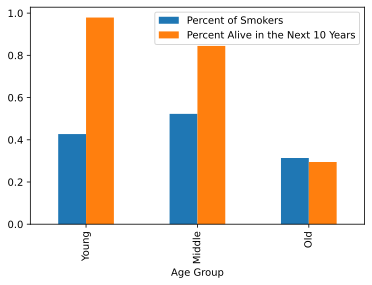

In [13]:
age_stats = (df
  .assign(age_group=lambda x: x["age"].apply(group_age).astype(age_dtype))
  .groupby("age_group")
  .agg(
    **{
      "Percent of Smokers": ("smokes", np.mean),
      "Percent Alive in the Next 10 Years": ("alive", np.mean),
      "Count": ("smokes", len)
    })
  )

display(age_stats)

age_stats.drop(columns="Count").plot(kind="bar")
plt.xlabel("Age Group")
plt.show()

# Smoking Is Bad

Age and smoking seem to be somewhat correlated.
In order to achieve a more clear vision, we will now try to "bucket" our ages into groups,
and divide the total population into smokers and non-smokers.

We can then visualize the probability of survival for 
each age range based on whether they smoke or not.

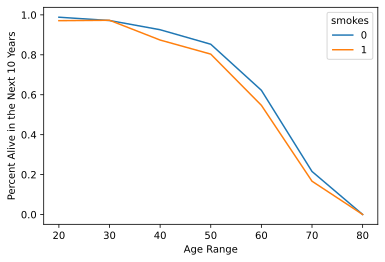

In [14]:
age_smoke_stats = (df
 .assign(age_range=lambda x: np.round(x["age"] / 10) * 10)
 .groupby(["smokes", "age_range"])
 .agg(**{
   "Percent Alive in the Next 10 Years": ("alive", np.mean),
 })
 .reset_index()
 .pivot(index="age_range", columns="smokes", values="Percent Alive in the Next 10 Years")
)

age_smoke_stats.plot()

plt.xlabel("Age Range")
plt.ylabel("Percent Alive in the Next 10 Years")

plt.show()

It is very clear now, that people who have smoked are actually a little less likely
to survive the next 10 years; regardless of their age.

Now this begs the question: "_How much_ does smoking actually decrease the odds of survival?"

# Quantifying the Effect

In [15]:
age_smoke_stats.head()

smokes,0,1
age_range,,
20.0,0.988372,0.971014
30.0,0.971831,0.972973
40.0,0.925620,0.873950
50.0,0.852941,0.803419
60.0,0.622222,0.547009


In [16]:
survival_diff = age_smoke_stats\
  .assign(diff=lambda x: x[0] - x[1])

survival_diff

smokes,0,1,diff
age_range,,,
20.0,0.988372,0.971014,0.017358
30.0,0.971831,0.972973,-0.001142
40.0,0.925620,0.873950,0.051670
50.0,0.852941,0.803419,0.049522
60.0,0.622222,0.547009,0.075214
70.0,0.215517,0.166667,0.048851
80.0,0.000000,0.000000,0.000000


In [17]:
survival_diff["diff"].mean()

0.03449607015272389

So in general, you're chances of survival will be about 3% higher
if you **don't** smoke. The bottom line is:

> _Never assume a conculsion to be correct, unless you've given it some critical thought._